This example shows how to use a `GridInducingVariationalGP` module. This classification module is designed for when the inputs of the function you're modeling are one-dimensional.

The use of inducing points allows for scaling up the training data by making computational complexity linear instead of cubic.

In this example, we’re modeling a function that is periodically labeled cycling every 1/8 (think of a square wave with period 1/4)

Kernel interpolation for scalable structured Gaussian processes (KISS-GP) was introduced in this paper:
http://proceedings.mlr.press/v37/wilson15.pdf

KISS-GP with SVI for classification was introduced in this paper:
https://papers.nips.cc/paper/6426-stochastic-variational-deep-kernel-learning.pdf

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from torch.autograd import Variable
# the train data points are spaced every 1/499 between 0 and 1 inclusive
train_x = Variable(torch.linspace(0, 1, 500)).cuda()
# Use the sign function (-1 if value <0, 1 if value>0) to assign periodic labels to the data
train_y = Variable(torch.sign(torch.cos(train_x.data * (8 * math.pi)))).cuda()

In [3]:
from torch import nn, optim
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood, BernoulliLikelihood
from gpytorch.random_variables import GaussianRandomVariable

In [4]:
# Create a model to classify, we use a GridInducingVariationalGP which exploits
# grid structure (the x data points are linspace)
# to get fast predictive distributions
class GPClassificationModel(gpytorch.models.GridInducingVariationalGP):
    def __init__(self):
        super(GPClassificationModel, self).__init__(grid_size=100, grid_bounds=[(0, 1)])
        # Near-zero constant mean
        self.mean_module = ConstantMean(prior=SmoothedBoxPrior(-5, 5))
        # The priors over the hyperparameters probably aren't necessary, but let's use them anyways
        self.covar_module = RBFKernel(
            log_lengthscale_prior=SmoothedBoxPrior(exp(-5), exp(6), sigma=0.1, log_transform=True)
        )
        self.register_parameter(
            name="log_outputscale",
            parameter=torch.nn.Parameter(torch.Tensor([0])),
            prior=SmoothedBoxPrior(exp(-5), exp(6), sigma=0.1, log_transform=True),
        )
        
    def forward(self,x):
        # Calc predictive mean (zero)
        mean_x = self.mean_module(x)
        # Calc predictive covariance
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        # Make predictive distribution from predictive mean and covariance
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred

# Initialize model
model = GPClassificationModel().cuda()
# Use Bernoulli Likelihood (warps via normal CDF to (0,1))
likelihood = BernoulliLikelihood().cuda()

In [5]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    # BernoulliLikelihood has no parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
# n_data refers to the amount of training data
mll = gpytorch.mlls.VariationalMarginalLogLikelihood(likelihood, model, n_data=len(train_y))

def train():
    # Use adam optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.1)
    optimizer.n_iter = 0
    total_iter = 200
    for i in range(total_iter):
        # Zero gradients out for new iteration
        optimizer.zero_grad()
        # Get output from model
        output = model(train_x)
        # Calculate loss
        loss = -mll(output, train_y)
        # Calc gradients
        loss.backward()
        print('Iter %d/%d - Loss: %.3f   log_lengthscale: %.3f' % (
            i + 1, total_iter, loss.data[0],
            model.covar_module.base_kernel_module.log_lengthscale.data.squeeze()[0],
        ))
        optimizer.step()

# See dkl_mnist.ipynb for explanation of use_toeplitz
with gpytorch.settings.use_toeplitz(False):
    # Get time spent
    %time train()

Iter 1/200 - Loss: 466.424   log_lengthscale: 0.000
Iter 2/200 - Loss: 465.799   log_lengthscale: -0.100
Iter 3/200 - Loss: 290.081   log_lengthscale: -0.177
Iter 4/200 - Loss: 247.155   log_lengthscale: -0.254
Iter 5/200 - Loss: 189.488   log_lengthscale: -0.331
Iter 6/200 - Loss: 125.033   log_lengthscale: -0.405
Iter 7/200 - Loss: 72.036   log_lengthscale: -0.476
Iter 8/200 - Loss: 54.739   log_lengthscale: -0.543
Iter 9/200 - Loss: 37.632   log_lengthscale: -0.606
Iter 10/200 - Loss: 31.019   log_lengthscale: -0.666
Iter 11/200 - Loss: 21.672   log_lengthscale: -0.726
Iter 12/200 - Loss: 14.138   log_lengthscale: -0.784
Iter 13/200 - Loss: 7.934   log_lengthscale: -0.840
Iter 14/200 - Loss: 14.829   log_lengthscale: -0.895
Iter 15/200 - Loss: 19.902   log_lengthscale: -0.944
Iter 16/200 - Loss: 22.650   log_lengthscale: -0.989
Iter 17/200 - Loss: 23.586   log_lengthscale: -1.033
Iter 18/200 - Loss: 26.247   log_lengthscale: -1.076
Iter 19/200 - Loss: 25.541   log_lengthscale: -1.11

Iter 159/200 - Loss: 0.970   log_lengthscale: -2.901
Iter 160/200 - Loss: 0.699   log_lengthscale: -2.901
Iter 161/200 - Loss: 0.626   log_lengthscale: -2.900
Iter 162/200 - Loss: 0.708   log_lengthscale: -2.899
Iter 163/200 - Loss: 0.851   log_lengthscale: -2.898
Iter 164/200 - Loss: 0.837   log_lengthscale: -2.898
Iter 165/200 - Loss: 1.032   log_lengthscale: -2.900
Iter 166/200 - Loss: 0.864   log_lengthscale: -2.906
Iter 167/200 - Loss: 1.097   log_lengthscale: -2.911
Iter 168/200 - Loss: 1.039   log_lengthscale: -2.916
Iter 169/200 - Loss: 0.811   log_lengthscale: -2.920
Iter 170/200 - Loss: 0.736   log_lengthscale: -2.924
Iter 171/200 - Loss: 0.663   log_lengthscale: -2.929
Iter 172/200 - Loss: 0.948   log_lengthscale: -2.936
Iter 173/200 - Loss: 0.656   log_lengthscale: -2.944
Iter 174/200 - Loss: 0.628   log_lengthscale: -2.954
Iter 175/200 - Loss: 0.695   log_lengthscale: -2.964
Iter 176/200 - Loss: 0.881   log_lengthscale: -2.974
Iter 177/200 - Loss: 0.858   log_lengthscale: 

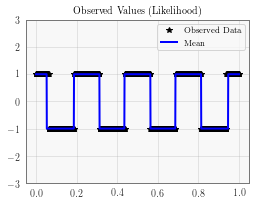

In [6]:
# Put mopdel and likelihood into eval mode
model.eval()
likelihood.eval()

# Initialize axes
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
# Test points are every 0.01 from 0 to 1 inclusive 
test_x = Variable(torch.linspace(0, 1, 1001)).cuda()
# Make predictions from model output Gaussian warped through Bernoulli likelihood
predictions = likelihood(model(test_x))

# Define plotting function
def ax_plot(ax, rand_var, title):
    # Black stars for trainng data
    ax.plot(train_x.data.cpu().numpy(), train_y.data.cpu().numpy(), 'k*')
    # Based of prediction probability label -1 or 1
    pred_labels = rand_var.mean().ge(0.5).float().mul(2).sub(1)
    # Plot test predictions as blue line
    ax.plot(test_x.data.cpu().numpy(), pred_labels.data.cpu().numpy(), 'b')
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)

# Call plot
ax_plot(observed_ax, predictions, 'Observed Values (Likelihood)')